The goal of this notebook is to create a student-teacher model where we first train a teacher on labeled data, and then use this teacher model to label more data, then we swap out the teacher with a student and train again over all the samples. 

# Loading data

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import datetime
import pickle
import time
import os
import pathlib
import matplotlib.pyplot as plt
import sys
 
# Some stuff to make utils-function work
sys.path.append('../utils')
from pipeline import *
from create_model import *
from utils import *
from unlabeled_utils import *
from evaluate_model import *
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

project_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
begin_time = time.time()

Some parameters

In [4]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/kvasir-capsule/labeled_new_splits/')
unlab_dir = pathlib.Path('/home/henriklg/master-thesis/data/kvasir-capsule/unlabeled_ttv/')

iteration = 0
dir_name = str(iteration)+"_teacher"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

conf = {
    # Dataset
    "data_dir": data_dir,
    "unlab_dir": unlab_dir,
    "ds_info": 'hypcap',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "aug_mult": 0.2,
    "resample": True,
    "class_weight": False,
    "shuffle_buffer_size": 2000,       # no shuffling: 0
    "seed": 2511,
    "neg_class": None,                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only supports 1 item
    # Model
    "model": 'EfficientNetB0',
    "weights": "imagenet",             # which weights to initialize the model with
    "dropout": 0.1,
    "num_epochs": 2,
    "batch_size": 8,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.001,
    "optimizer": 'Adam',
    "final_activation": 'softmax',     # sigmoid for binary ds
    # Callbacks
    "tensorboard": False,
    "decay_rate": 0,                   # 128:0.25   64:1.0   32:4.0   16:16   8:64
    "checkpoint": False,
    "early_stopp_patience": 7,         # disable: 0
    # Misc
    "verbosity": 1,
    "keep_thresh": 0.95,
    "pseudo_thresh": 2000,
    "class_limit": 2000,
    "dir_name": dir_name,
    "log_dir": log_dir,
    "cache_dir": "./cache",
    }

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [5]:
ds = create_dataset(conf)

Category                    : train | test  | val   | total | % of total 
------------------------------------------------------------------------
Reduced Mucosal View        :   915 |  1484 |  1484 |  3883 |  5.50%
Lymphoid Hyperplasia        :   224 |   368 |   368 |   960 |  1.36%
Foreign Bodies              :   753 |    23 |    23 |   799 |  1.13%
Ulcer                       :   709 |   145 |   145 |   999 |  1.41%
Normal mucosa               : 16618 | 17988 | 17988 | 52594 | 74.49%
Erosion                     :   207 |   232 |   232 |   671 |  0.95%
Pylorus                     :   592 |   937 |   937 |  2466 |  3.49%
Ileo-cecal valve            :  2343 |  1846 |  1846 |  6035 |  8.55%
Blood                       :    22 |   424 |   424 |   870 |  1.23%
Angiectasia                 :   795 |    71 |    71 |   937 |  1.33%
Erythematous                :   127 |   132 |   132 |   391 |  0.55%
------------------------------------------------------------------------
Total                

In [6]:
# First iteration only
sanity = []
ds["unlab"] = create_unlab_ds(conf)
datasets_bin = [tf_bincount(ds["clean_train"], conf["num_classes"])]
ds["combined_train"] = ds["clean_train"]

Loaded 2627234 images into unlabeled_ds.


## Recover from previous checkpoint

# Step 1: Train a teacher model on labeled images

In [7]:
model = create_model(conf)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5643      
Total params: 4,711,079
Trainable params: 4,669,063
Non-trainable params: 42,016
_________________________________________

In [8]:
callbacks = create_callbacks(conf)

In [9]:
class_weights = get_class_weights(ds["train"], conf)

### Train the teacher model

In [11]:
start_time = time.time()

history = model.fit(
        ds["train"],
        steps_per_epoch = conf["steps"]["train"],
        epochs = conf["num_epochs"],
        validation_data = ds["test"],
        validation_steps = conf["steps"]["test"],
        validation_freq = 1,
        class_weight = class_weights,
        callbacks = callbacks,
        verbose = 1
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

Train for 2913 steps, validate for 2956 steps
Epoch 1/2
2913/2913 [==============================] - 123s 42ms/step - loss: 0.4978 - sparse_categorical_accuracy: 0.8433 - val_loss: 2.7559 - val_sparse_categorical_accuracy: 0.4745
Epoch 2/2
2913/2913 [==============================] - 112s 38ms/step - loss: 0.2432 - sparse_categorical_accuracy: 0.9219 - val_loss: 2.9057 - val_sparse_categorical_accuracy: 0.3899
Time spent on training: 3.92 minutes.


### Evaluate the model

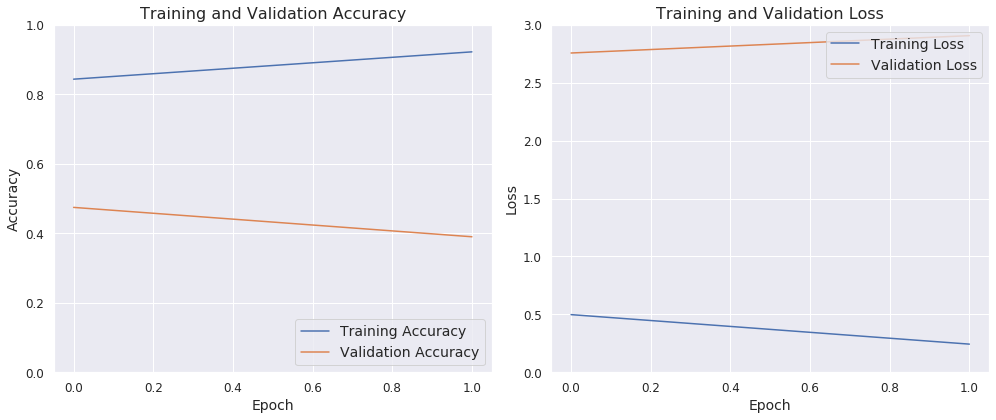

2956/2956 - 24s - loss: 2.9057 - sparse_categorical_accuracy: 0.3899
23650/23650 [==============================] - 12s 513us/sample
                      precision    recall  f1-score   support

Reduced Mucosal View      0.154     0.080     0.105      1484
Lymphoid Hyperplasia      0.237     0.062     0.099       368
      Foreign Bodies      0.007     0.522     0.013        23
               Ulcer      0.118     0.028     0.045       145
       Normal mucosa      0.950     0.398     0.561     17988
             Erosion      0.015     0.091     0.025       232
             Pylorus      0.096     0.701     0.170       937
    Ileo-cecal valve      0.260     0.639     0.370      1846
               Blood      0.000     0.000     0.000       424
         Angiectasia      0.104     0.521     0.173        71
        Erythematous      0.004     0.008     0.005       132

            accuracy                          0.390     23650
           macro avg      0.177     0.277     0.142     236

In [15]:
evaluate_model(model, history, ds, conf)

# Step 2: use the teacher to generate pseudo labels on unlabeled images

### Run predictions on all unlabeled images

In [12]:
conf["pseudo_thresh"] = 2000

In [13]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

Press 'Interrupt Kernel' to save and exit.


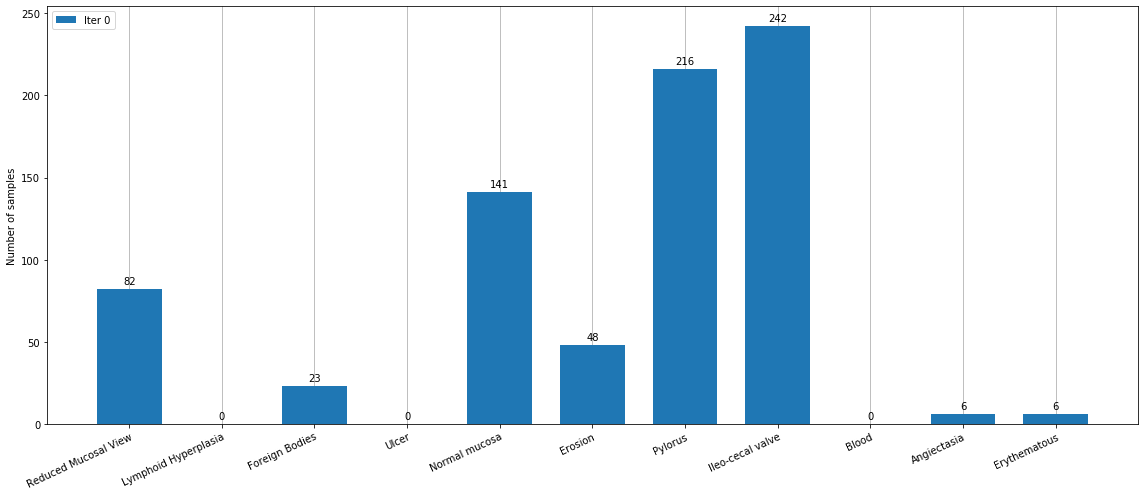


Total run time: 0.9 min.
Found 764 new samples in unlabeled_ds after looking at 2001 images.


In [14]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

## Inspect the classified images

In [26]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

Limit set by user with 2000 samples
--------------------------------------------------
Reduced Mucosal View       : added 82/82 samples
Lymphoid Hyperplasia       : added 0/0 samples
Foreign Bodies             : added 23/23 samples
Ulcer                      : added 0/0 samples
Normal mucosa              : added 0/141 samples
Erosion                    : added 48/48 samples
Pylorus                    : added 216/216 samples
Ileo-cecal valve           : added 0/242 samples
Blood                      : added 0/0 samples
Angiectasia                : added 6/6 samples
Erythematous               : added 6/6 samples
--------------------------------------------------
Added a total of 381 samples to the training dataset. New dataset size is 23686.


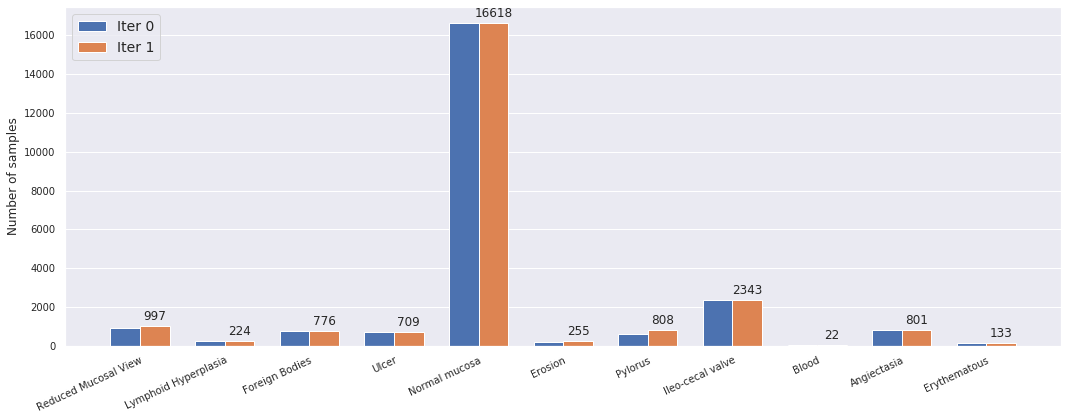

{'added_samples': 381,
 'last_unlab_size': 2627234,
 'curr_unlab_size': 2626853,
 'last_train_size': 23305,
 'curr_train_size': 23686}

In [18]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# Step 3: Train a student model on the combination of labeled images and pseudo labeled images

Now we have trained a teacher model, and used that model to predict on unlabeled dataset to create more samples with psudo-labels.  
It's time for swapping the teacher with the student!

In [17]:
# Make changes
dir_name = str(iteration)+"_student"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.6
# Model
conf["model"] = 'EfficientNetB4'
conf["dropout"] = 0.2

In [18]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )


---- Ratios before resampling ---- 
[1.33306861e-03 5.67263239e-02 2.33712454e-02 1.70178972e-03
 1.06078226e-02 2.26054401e-02 2.18679978e-02 1.43801231e-02
 5.67263239e-02 8.31607908e-02 1.06361857e-02 2.62359248e-02
 2.83631619e-04 6.64095073e-01 6.26825879e-03]

---- Ratios after resampling ----
[0.06396484 0.06601562 0.06201172 0.06591797 0.06640625 0.06884766
 0.06679688 0.06787109 0.06552734 0.06640625 0.06787109 0.06982422
 0.07011719 0.06738281 0.06503906]


In [23]:
# create model, callbacks and weights
student_model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 4, 4, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1792)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               918016    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                7695      
Total params: 18,599,527
Trainable params: 18,474,327
Non-trainable params: 125,200
____________________________________

In [24]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

Train for 4407 steps, validate for 882 steps
Epoch 1/30
4407/4407 [==============================] - 367s 83ms/step - loss: 0.8982 - sparse_categorical_accuracy: 0.7217 - val_loss: 1.8526 - val_sparse_categorical_accuracy: 0.5734
Epoch 2/30
4407/4407 [==============================] - 326s 74ms/step - loss: 0.5065 - sparse_categorical_accuracy: 0.8426 - val_loss: 1.8304 - val_sparse_categorical_accuracy: 0.4556
Epoch 3/30
4407/4407 [==============================] - 318s 72ms/step - loss: 0.3785 - sparse_categorical_accuracy: 0.8819 - val_loss: 0.9568 - val_sparse_categorical_accuracy: 0.7071
Epoch 4/30
4407/4407 [==============================] - 320s 73ms/step - loss: 0.3081 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.7863 - val_sparse_categorical_accuracy: 0.7568
Epoch 5/30
4407/4407 [==============================] - 328s 74ms/step - loss: 0.2671 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.7825
Epoch 6/30
4407/4407 [========

### Evaluate the model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./logs/20200623-140511/0_student/model/assets


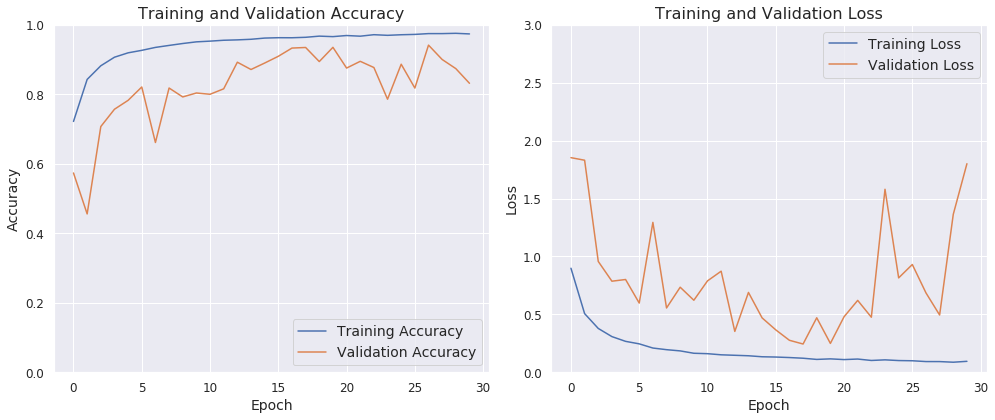

882/882 - 18s - loss: 2.3887 - sparse_categorical_accuracy: 0.8299
7063/7063 [==============================] - 12s 2ms/sample
                      precision    recall  f1-score   support

               Polyp      0.909     1.000     0.952        10
Reduced Mucosal View      0.855     0.953     0.901       360
              Mucosa      0.598     0.983     0.743       174
             Unknown      0.157     0.929     0.268        14
Lymphoid Hyperplasia      0.890     0.936     0.912        78
      Foreign Bodies      0.665     0.983     0.793       117
               Ulcer      0.601     0.992     0.749       129
             Erosion      0.758     0.758     0.758        66
             Pylorus      0.452     0.870     0.595       230
    Ileo-cecal valve      0.606     0.959     0.743       629
               Blood      0.877     0.955     0.914        67
         Angiectasia      0.571     0.985     0.723       130
             Hematin      0.500     1.000     0.667         2
    

In [29]:
evaluate_model(model, history, ds, conf)

In [30]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

Press 'Interrupt Kernel' to save and exit.


Exception ignored in: <function TF_Output.<lambda> at 0x7ff190681b90>
Traceback (most recent call last):
  File "/home/henriklg/anaconda3/envs/TF2/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py", line 1178, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt


Exiting


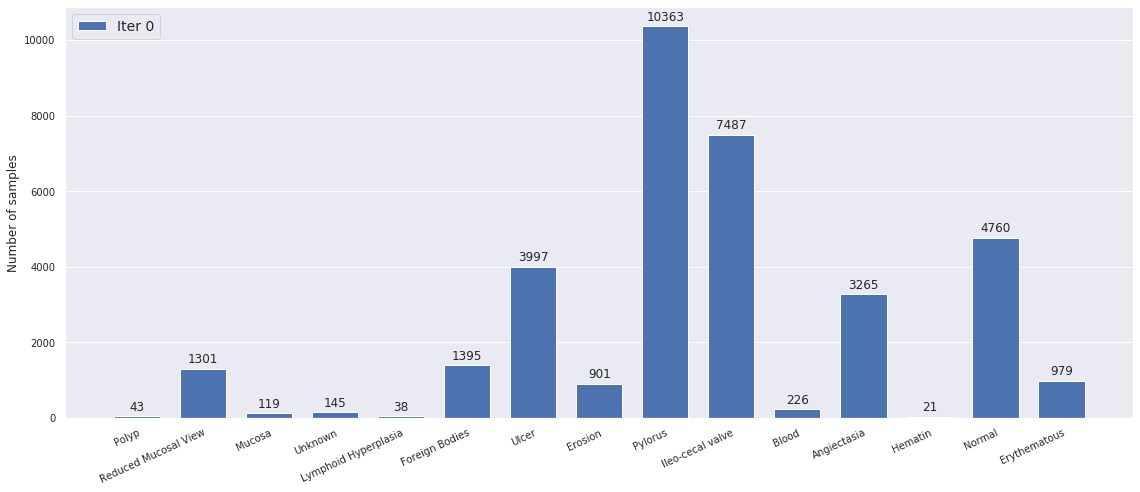


Total run time: 78.7 min.
Found 35040 new samples in unlabeled_ds after looking at 109391 images.


In [31]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [32]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

Limit set by user with 2000 samples
--------------------------------------------------
Polyp                      : added 43/43 samples
Reduced Mucosal View       : added 0/1301 samples
Mucosa                     : added 119/119 samples
Unknown                    : added 145/145 samples
Lymphoid Hyperplasia       : added 38/38 samples
Foreign Bodies             : added 1203/1395 samples
Ulcer                      : added 1229/3997 samples
Erosion                    : added 901/901 samples
Pylorus                    : added 0/10363 samples
Ileo-cecal valve           : added 0/7487 samples
Blood                      : added 226/226 samples
Angiectasia                : added 1075/3265 samples
Hematin                    : added 21/21 samples
Normal                     : added 0/4760 samples
Erythematous               : added 979/979 samples
--------------------------------------------------
Added a total of 5979 samples to the training dataset. New dataset size is 41236.


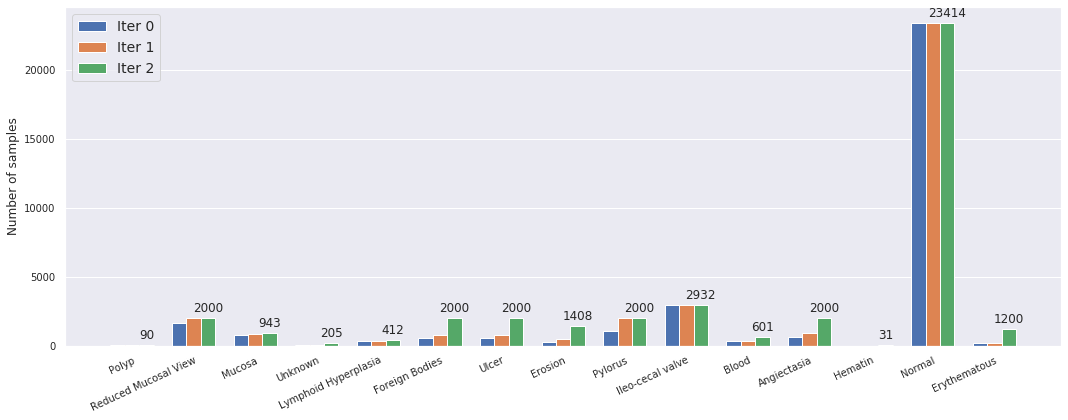

{'added_samples': 5979,
 'last_unlab_size': 2624902,
 'curr_unlab_size': 2618923,
 'last_train_size': 35257,
 'curr_train_size': 41236}

In [33]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# Step 4: Iterate this algorithm a few times by treating the student as a teacher to relabel the unlabeled data and training a new student

# Second iteration - Part 1
# --- Teacher 2 ---

In [34]:
# Make changes
iteration += 1
dir_name = str(iteration)+"_teacher"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[1]["curr_train_size"]
conf["aug_mult"] = 0.2
# Model
conf["model"] = 'EfficientNetB0'
conf["dropout"] = 0.1

In [35]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )


---- Ratios before resampling ---- 
[0.00218256 0.04850131 0.02286837 0.00497138 0.00999127 0.04850131
 0.04850131 0.03414492 0.04850131 0.07110292 0.01457464 0.04850131
 0.00075177 0.56780483 0.02910079]

---- Ratios after resampling ----
[0.06396484 0.06601562 0.06201172 0.06591797 0.06640625 0.06884766
 0.06679688 0.06787109 0.06552734 0.06640625 0.06787109 0.06982422
 0.07011719 0.06738281 0.06503906]


In [36]:
# create model, callbacks and weights
model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                7695      
Total params: 4,713,131
Trainable params: 4,671,115
Non-trainable params: 42,016
_______________________________________

In [37]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

Train for 5154 steps, validate for 882 steps
Epoch 1/30
5154/5154 [==============================] - 227s 44ms/step - loss: 0.8096 - sparse_categorical_accuracy: 0.7510 - val_loss: 2.0170 - val_sparse_categorical_accuracy: 0.3591
Epoch 2/30
5154/5154 [==============================] - 190s 37ms/step - loss: 0.5122 - sparse_categorical_accuracy: 0.8417 - val_loss: 0.5179 - val_sparse_categorical_accuracy: 0.8512
Epoch 3/30
5154/5154 [==============================] - 193s 37ms/step - loss: 0.4268 - sparse_categorical_accuracy: 0.8676 - val_loss: 1.1263 - val_sparse_categorical_accuracy: 0.6541
Epoch 4/30
5154/5154 [==============================] - 194s 38ms/step - loss: 0.3510 - sparse_categorical_accuracy: 0.8908 - val_loss: 0.5790 - val_sparse_categorical_accuracy: 0.8312
Epoch 5/30
5154/5154 [==============================] - 194s 38ms/step - loss: 0.3320 - sparse_categorical_accuracy: 0.8989 - val_loss: 2.4638 - val_sparse_categorical_accuracy: 0.3921
Epoch 6/30
5154/5154 [========

## Evaluate the model

INFO:tensorflow:Assets written to: ./logs/20200623-140511/1_teacher/model/assets


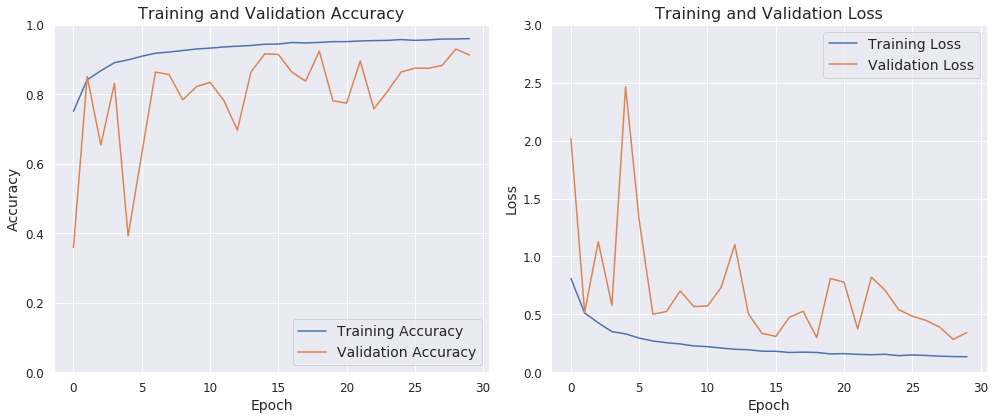

882/882 - 8s - loss: 0.3541 - sparse_categorical_accuracy: 0.9050
7063/7063 [==============================] - 4s 621us/sample
                      precision    recall  f1-score   support

               Polyp      1.000     0.900     0.947        10
Reduced Mucosal View      0.788     0.983     0.875       360
              Mucosa      0.820     0.971     0.889       174
             Unknown      0.293     0.857     0.436        14
Lymphoid Hyperplasia      0.814     0.897     0.854        78
      Foreign Bodies      0.679     0.940     0.789       117
               Ulcer      0.849     1.000     0.918       129
             Erosion      0.659     0.818     0.730        66
             Pylorus      0.744     0.935     0.829       230
    Ileo-cecal valve      0.727     0.989     0.838       629
               Blood      0.857     0.985     0.917        67
         Angiectasia      0.906     0.885     0.895       130
             Hematin      1.000     1.000     1.000         2
    

In [38]:
evaluate_model(model, history, ds, conf)

In [39]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

Press 'Interrupt Kernel' to save and exit.


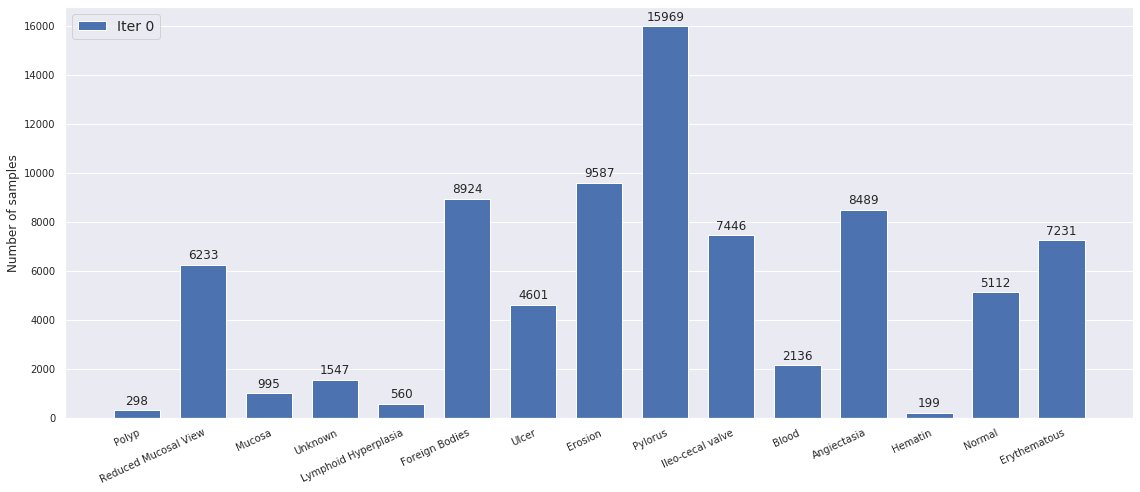


Total run time: 111.0 min.
Found 79327 new samples in unlabeled_ds after looking at 200001 images.


In [40]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [41]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

Limit set by user with 2000 samples
--------------------------------------------------
Polyp                      : added 298/298 samples
Reduced Mucosal View       : added 0/6233 samples
Mucosa                     : added 995/995 samples
Unknown                    : added 1547/1547 samples
Lymphoid Hyperplasia       : added 560/560 samples
Foreign Bodies             : added 0/8924 samples
Ulcer                      : added 0/4601 samples
Erosion                    : added 592/9587 samples
Pylorus                    : added 0/15969 samples
Ileo-cecal valve           : added 0/7446 samples
Blood                      : added 1399/2136 samples
Angiectasia                : added 0/8489 samples
Hematin                    : added 199/199 samples
Normal                     : added 0/5112 samples
Erythematous               : added 800/7231 samples
--------------------------------------------------
Added a total of 6390 samples to the training dataset. New dataset size is 47626.


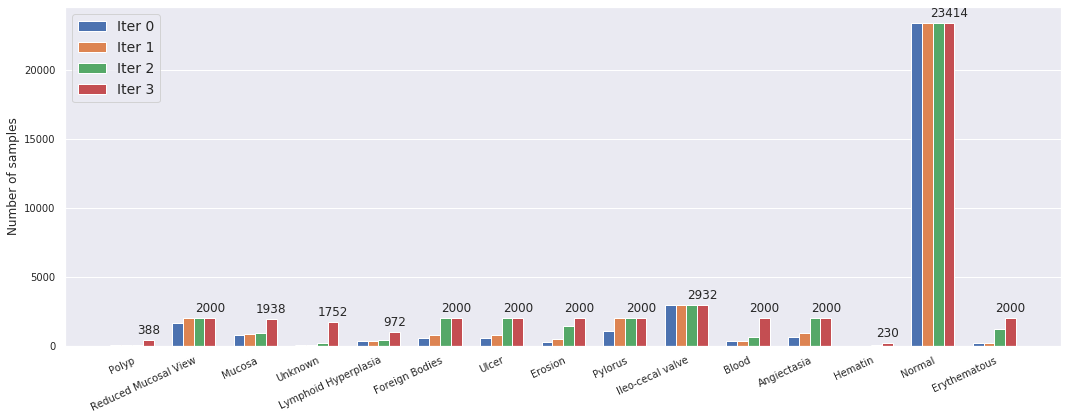

{'added_samples': 6390,
 'last_unlab_size': 2618923,
 'curr_unlab_size': 2612533,
 'last_train_size': 41236,
 'curr_train_size': 47626}

In [42]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# Second Iteration - part 2
# -- Student 2 ---

In [43]:
# Make changes
dir_name = str(iteration)+"_student"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.6
# Model
conf["model"] = 'EfficientNetB4'
conf["dropout"] = 0.2

In [44]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )


---- Ratios before resampling ---- 
[0.00814681 0.04199387 0.04069206 0.03678663 0.02040902 0.04199387
 0.04199387 0.04199387 0.04199387 0.06156301 0.04199387 0.04199387
 0.00482929 0.49162222 0.04199387]

---- Ratios after resampling ----
[0.06396484 0.06601562 0.06201172 0.06591797 0.06640625 0.06884766
 0.06679688 0.06787109 0.06552734 0.06640625 0.06787109 0.06982422
 0.07011719 0.06738281 0.06503906]


In [45]:
# create model, callbacks and weights
model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 4, 4, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1792)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               918016    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)                7695      
Total params: 18,599,527
Trainable params: 18,474,327
Non-trainable params: 125,200
____________________________________

In [46]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

Train for 5953 steps, validate for 882 steps
Epoch 1/30
5953/5953 [==============================] - 517s 87ms/step - loss: 1.0473 - sparse_categorical_accuracy: 0.6820 - val_loss: 1.8274 - val_sparse_categorical_accuracy: 0.4592
Epoch 2/30
5953/5953 [==============================] - 412s 69ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.7966 - val_loss: 1.8905 - val_sparse_categorical_accuracy: 0.4901
Epoch 3/30
5953/5953 [==============================] - 414s 69ms/step - loss: 0.4959 - sparse_categorical_accuracy: 0.8502 - val_loss: 1.0569 - val_sparse_categorical_accuracy: 0.6986
Epoch 4/30
5953/5953 [==============================] - 413s 69ms/step - loss: 0.4465 - sparse_categorical_accuracy: 0.8641 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.8006
Epoch 5/30
5953/5953 [==============================] - 430s 72ms/step - loss: 0.3816 - sparse_categorical_accuracy: 0.8862 - val_loss: 0.8497 - val_sparse_categorical_accuracy: 0.7300
Epoch 6/30
5953/5953 [========

## Evaluate the model

INFO:tensorflow:Assets written to: ./logs/20200623-140511/1_student/model/assets


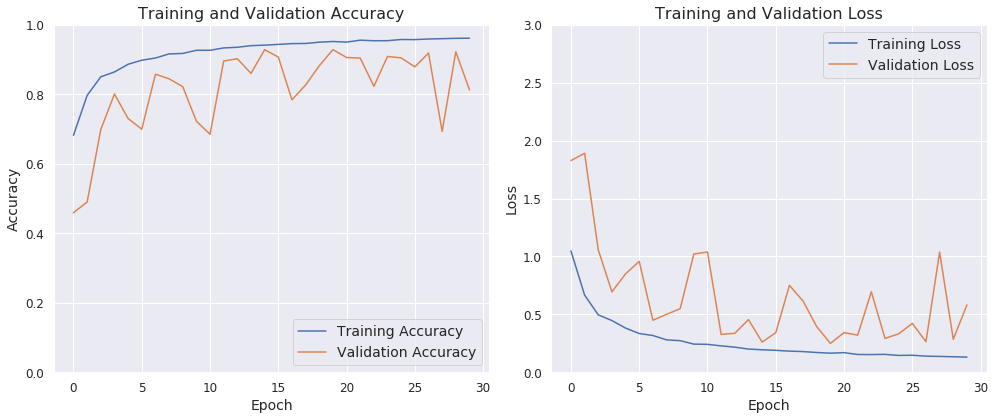

882/882 - 17s - loss: 0.2344 - sparse_categorical_accuracy: 0.9324
7063/7063 [==============================] - 10s 1ms/sample
                      precision    recall  f1-score   support

               Polyp      0.909     1.000     0.952        10
Reduced Mucosal View      0.819     0.983     0.894       360
              Mucosa      0.850     0.879     0.864       174
             Unknown      0.317     0.929     0.473        14
Lymphoid Hyperplasia      0.661     1.000     0.796        78
      Foreign Bodies      0.699     0.991     0.820       117
               Ulcer      0.876     0.984     0.927       129
             Erosion      0.651     0.621     0.636        66
             Pylorus      0.924     0.796     0.855       230
    Ileo-cecal valve      0.922     0.963     0.942       629
               Blood      0.851     0.940     0.894        67
         Angiectasia      0.829     0.969     0.894       130
             Hematin      1.000     0.500     0.667         2
    

In [47]:
evaluate_model(model, history, ds, conf)

In [48]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

Press 'Interrupt Kernel' to save and exit.


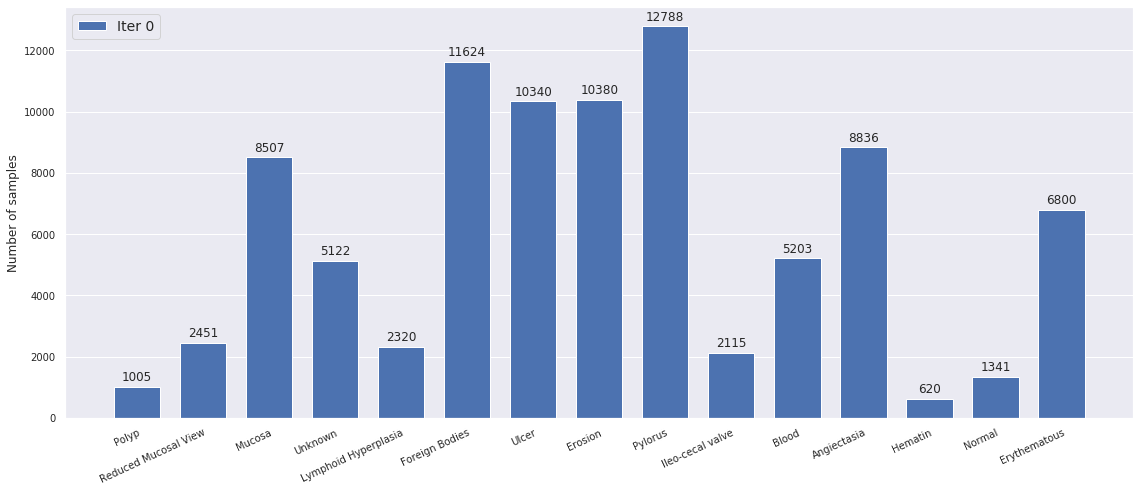


Total run time: 174.8 min.
Found 89452 new samples in unlabeled_ds after looking at 200001 images.


In [49]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [50]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

Limit set by user with 2000 samples
--------------------------------------------------
Polyp                      : added 1005/1005 samples
Reduced Mucosal View       : added 0/2451 samples
Mucosa                     : added 62/8507 samples
Unknown                    : added 248/5122 samples
Lymphoid Hyperplasia       : added 1028/2320 samples
Foreign Bodies             : added 0/11624 samples
Ulcer                      : added 0/10340 samples
Erosion                    : added 0/10380 samples
Pylorus                    : added 0/12788 samples
Ileo-cecal valve           : added 0/2115 samples
Blood                      : added 0/5203 samples
Angiectasia                : added 0/8836 samples
Hematin                    : added 620/620 samples
Normal                     : added 0/1341 samples
Erythematous               : added 0/6800 samples
--------------------------------------------------
Added a total of 2963 samples to the training dataset. New dataset size is 50589.


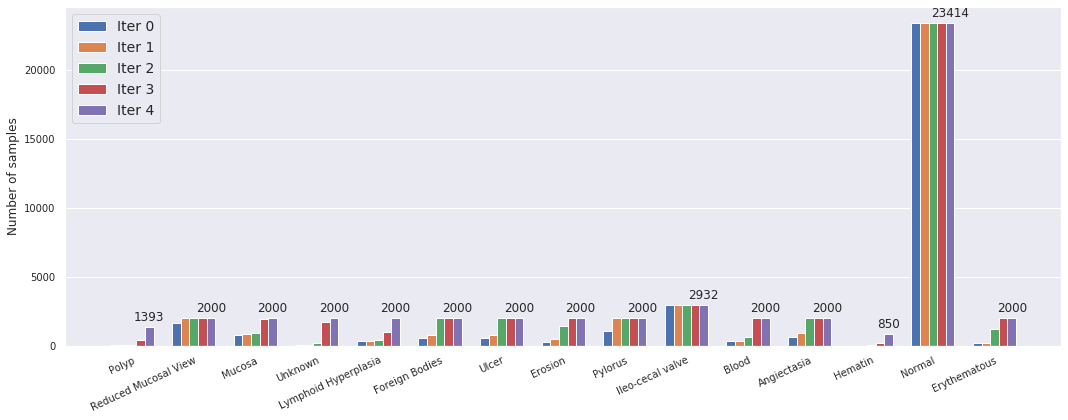

{'added_samples': 2963,
 'last_unlab_size': 2612533,
 'curr_unlab_size': 2609570,
 'last_train_size': 47626,
 'curr_train_size': 50589}

In [51]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# Third iteration - Part 1
# --- Teacher 3 ---

In [52]:
# Make changes
iteration += 1
dir_name = str(iteration)+"_teacher"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.2
# Model
conf["model"] = 'EfficientNetB0'
conf["dropout"] = 0.1

In [53]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )


---- Ratios before resampling ---- 
[0.02753563 0.03953429 0.03953429 0.03953429 0.03953429 0.03953429
 0.03953429 0.03953429 0.03953429 0.05795726 0.03953429 0.03953429
 0.01680207 0.46282789 0.03953429]

---- Ratios after resampling ----
[0.06396484 0.06601562 0.06201172 0.06591797 0.06640625 0.06884766
 0.06679688 0.06787109 0.06552734 0.06640625 0.06787109 0.06982422
 0.07011719 0.06738281 0.06503906]


In [54]:
# create model, callbacks and weights
model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                7695      
Total params: 4,713,131
Trainable params: 4,671,115
Non-trainable params: 42,016
_______________________________________

In [55]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

Train for 6323 steps, validate for 882 steps
Epoch 1/30
6323/6323 [==============================] - 370s 58ms/step - loss: 0.8868 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.9654 - val_sparse_categorical_accuracy: 0.7346
Epoch 2/30
6323/6323 [==============================] - 221s 35ms/step - loss: 0.5998 - sparse_categorical_accuracy: 0.8150 - val_loss: 0.7976 - val_sparse_categorical_accuracy: 0.7402
Epoch 3/30
6323/6323 [==============================] - 222s 35ms/step - loss: 0.4853 - sparse_categorical_accuracy: 0.8519 - val_loss: 1.6844 - val_sparse_categorical_accuracy: 0.4942
Epoch 4/30
6323/6323 [==============================] - 223s 35ms/step - loss: 0.4124 - sparse_categorical_accuracy: 0.8738 - val_loss: 0.7113 - val_sparse_categorical_accuracy: 0.8082
Epoch 5/30
6323/6323 [==============================] - 222s 35ms/step - loss: 0.3705 - sparse_categorical_accuracy: 0.8882 - val_loss: 0.6867 - val_sparse_categorical_accuracy: 0.7965
Epoch 6/30
6323/6323 [========

## Evaluate the model

INFO:tensorflow:Assets written to: ./logs/20200623-140511/2_teacher/model/assets


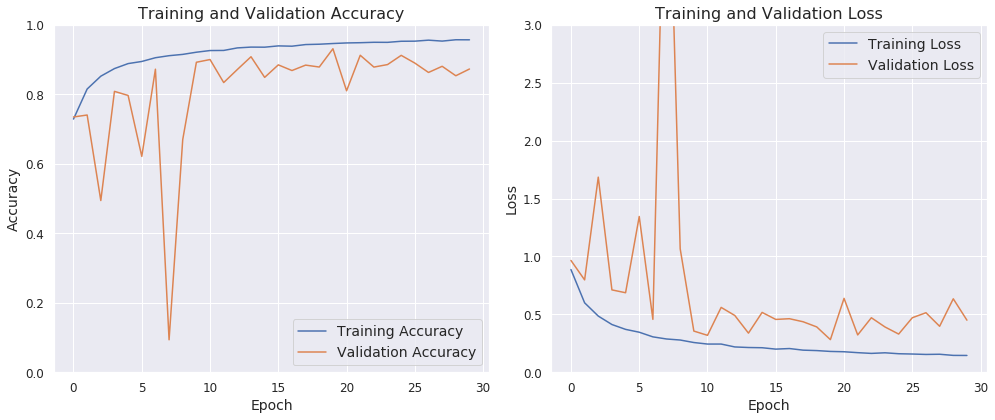

882/882 - 8s - loss: 0.2853 - sparse_categorical_accuracy: 0.9297
7063/7063 [==============================] - 4s 589us/sample
                      precision    recall  f1-score   support

               Polyp      0.417     1.000     0.588        10
Reduced Mucosal View      0.906     0.964     0.934       360
              Mucosa      0.832     0.914     0.871       174
             Unknown      0.294     0.714     0.417        14
Lymphoid Hyperplasia      0.704     0.885     0.784        78
      Foreign Bodies      0.825     0.966     0.890       117
               Ulcer      0.865     0.946     0.904       129
             Erosion      0.667     0.455     0.541        66
             Pylorus      0.831     0.857     0.844       230
    Ileo-cecal valve      0.916     0.957     0.936       629
               Blood      0.725     0.866     0.789        67
         Angiectasia      0.796     0.992     0.884       130
             Hematin      0.091     0.500     0.154         2
    

In [56]:
evaluate_model(model, history, ds, conf)

In [57]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

Press 'Interrupt Kernel' to save and exit.


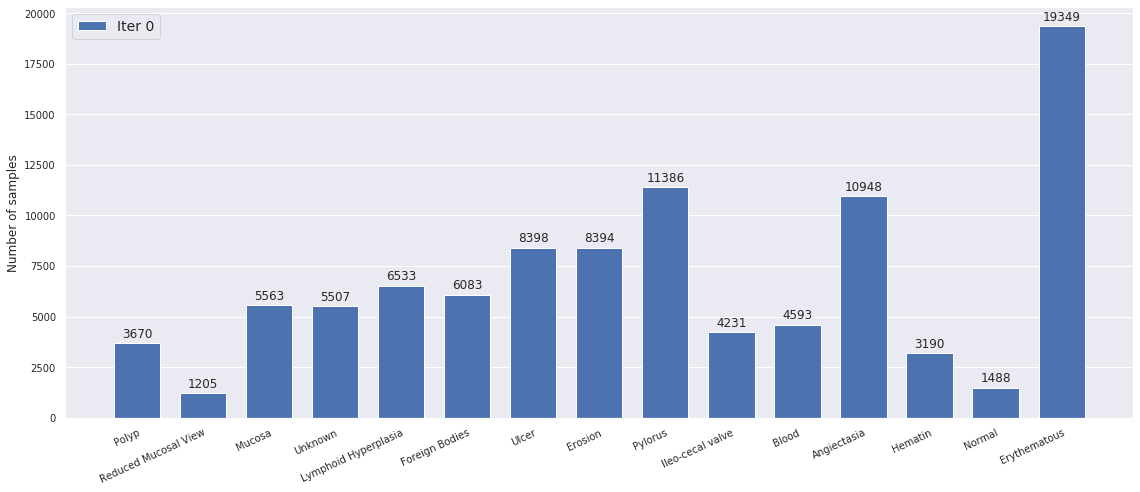


Total run time: 136.7 min.
Found 100538 new samples in unlabeled_ds after looking at 200001 images.


In [58]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [59]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

Limit set by user with 2000 samples
--------------------------------------------------
Polyp                      : added 607/3670 samples
Reduced Mucosal View       : added 0/1205 samples
Mucosa                     : added 0/5563 samples
Unknown                    : added 0/5507 samples
Lymphoid Hyperplasia       : added 0/6533 samples
Foreign Bodies             : added 0/6083 samples
Ulcer                      : added 0/8398 samples
Erosion                    : added 0/8394 samples
Pylorus                    : added 0/11386 samples
Ileo-cecal valve           : added 0/4231 samples
Blood                      : added 0/4593 samples
Angiectasia                : added 0/10948 samples
Hematin                    : added 1150/3190 samples
Normal                     : added 0/1488 samples
Erythematous               : added 0/19349 samples
--------------------------------------------------
Added a total of 1757 samples to the training dataset. New dataset size is 52346.


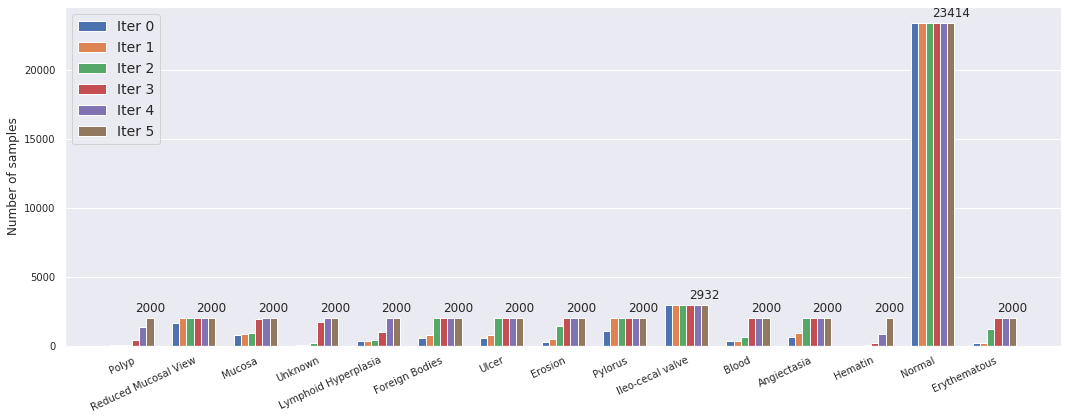

{'added_samples': 1757,
 'last_unlab_size': 2609570,
 'curr_unlab_size': 2607813,
 'last_train_size': 50589,
 'curr_train_size': 52346}

In [60]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# Third Iteration - part 2
# -- Student 3 ---

In [61]:
# Make changes
dir_name = str(iteration)+"_student"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.6
# Model
conf["model"] = 'EfficientNetB4'
conf["dropout"] = 0.2

In [62]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )


---- Ratios before resampling ---- 
[0.03820731 0.03820731 0.03820731 0.03820731 0.03820731 0.03820731
 0.03820731 0.03820731 0.03820731 0.05601192 0.03820731 0.03820731
 0.03820731 0.44729301 0.03820731]

---- Ratios after resampling ----
[0.06396484 0.06601562 0.06201172 0.06591797 0.06640625 0.06884766
 0.06679688 0.06787109 0.06552734 0.06640625 0.06787109 0.06982422
 0.07011719 0.06738281 0.06503906]


In [63]:
# create model, callbacks and weights
model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 4, 4, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1792)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1792)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               918016    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 15)                7695      
Total params: 18,599,527
Trainable params: 18,474,327
Non-trainable params: 125,200
____________________________________

In [64]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

Train for 6543 steps, validate for 882 steps
Epoch 1/30
6543/6543 [==============================] - 638s 98ms/step - loss: 1.0484 - sparse_categorical_accuracy: 0.6813 - val_loss: 1.8056 - val_sparse_categorical_accuracy: 0.5954
Epoch 2/30
6543/6543 [==============================] - 480s 73ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.7983 - val_loss: 1.4002 - val_sparse_categorical_accuracy: 0.5940
Epoch 3/30
6543/6543 [==============================] - 474s 72ms/step - loss: 0.5355 - sparse_categorical_accuracy: 0.8377 - val_loss: 1.0324 - val_sparse_categorical_accuracy: 0.6739
Epoch 4/30
6543/6543 [==============================] - 465s 71ms/step - loss: 0.4459 - sparse_categorical_accuracy: 0.8655 - val_loss: 0.9024 - val_sparse_categorical_accuracy: 0.7024
Epoch 5/30
6543/6543 [==============================] - 467s 71ms/step - loss: 0.3856 - sparse_categorical_accuracy: 0.8835 - val_loss: 0.7800 - val_sparse_categorical_accuracy: 0.8162
Epoch 6/30
6543/6543 [========

## Evaluate the model

INFO:tensorflow:Assets written to: ./logs/20200623-140511/2_student/model/assets


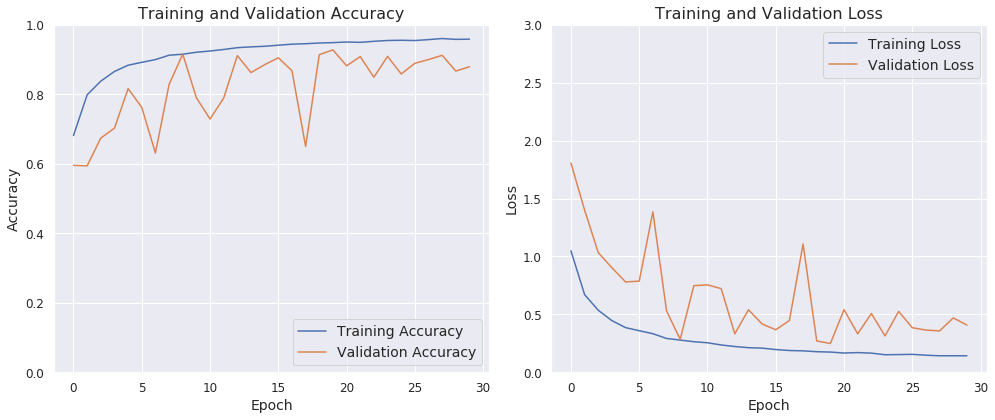

882/882 - 19s - loss: 0.2478 - sparse_categorical_accuracy: 0.9306
7063/7063 [==============================] - 12s 2ms/sample
                      precision    recall  f1-score   support

               Polyp      0.312     1.000     0.476        10
Reduced Mucosal View      0.892     0.942     0.916       360
              Mucosa      0.872     0.902     0.887       174
             Unknown      0.464     0.929     0.619        14
Lymphoid Hyperplasia      0.552     0.949     0.698        78
      Foreign Bodies      0.752     0.983     0.852       117
               Ulcer      0.908     0.992     0.948       129
             Erosion      0.742     0.742     0.742        66
             Pylorus      0.883     0.822     0.851       230
    Ileo-cecal valve      0.858     0.976     0.913       629
               Blood      0.756     0.925     0.832        67
         Angiectasia      0.943     0.885     0.913       130
             Hematin      0.118     1.000     0.211         2
    

In [65]:
evaluate_model(model, history, ds, conf)

In [66]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

Press 'Interrupt Kernel' to save and exit.


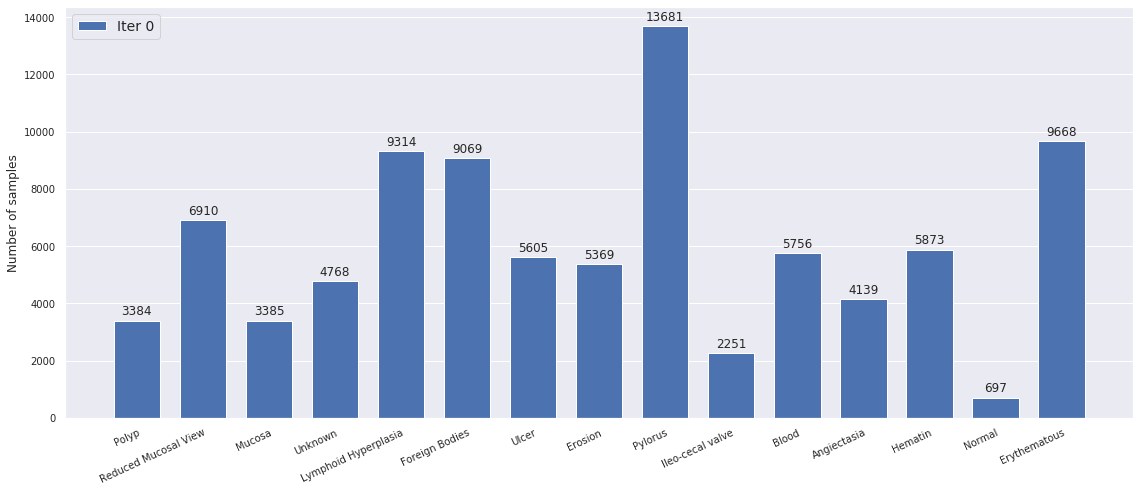


Total run time: 195.3 min.
Found 89869 new samples in unlabeled_ds after looking at 200001 images.


In [67]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [68]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

Limit set by user with 2000 samples
--------------------------------------------------
Polyp                      : added 0/3384 samples
Reduced Mucosal View       : added 0/6910 samples
Mucosa                     : added 0/3385 samples
Unknown                    : added 0/4768 samples
Lymphoid Hyperplasia       : added 0/9314 samples
Foreign Bodies             : added 0/9069 samples
Ulcer                      : added 0/5605 samples
Erosion                    : added 0/5369 samples
Pylorus                    : added 0/13681 samples
Ileo-cecal valve           : added 0/2251 samples
Blood                      : added 0/5756 samples
Angiectasia                : added 0/4139 samples
Hematin                    : added 0/5873 samples
Normal                     : added 0/697 samples
Erythematous               : added 0/9668 samples
--------------------------------------------------
Added a total of 0 samples to the training dataset. New dataset size is 52346.


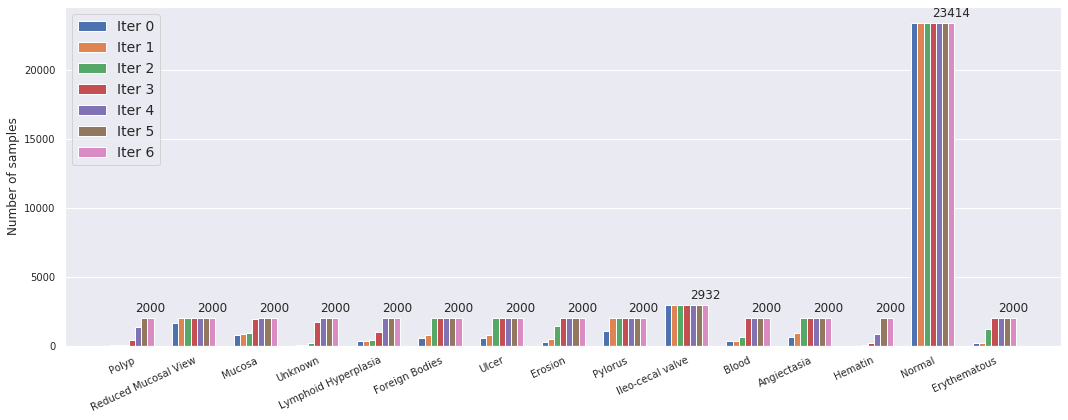

{'added_samples': 0,
 'last_unlab_size': 2607813,
 'curr_unlab_size': 2607813,
 'last_train_size': 52346,
 'curr_train_size': 52346}

In [69]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# 4th iteration - Part 1
# --- Teacher 4 ---

In [70]:
# Make changes
iteration += 1
dir_name = str(iteration)+"_teacher"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.2
# Model
conf["model"] = 'EfficientNetB0'
conf["dropout"] = 0.1

conf["class_limit"] = 2500

In [71]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )


---- Ratios before resampling ---- 
[0.03820731 0.03820731 0.03820731 0.03820731 0.03820731 0.03820731
 0.03820731 0.03820731 0.03820731 0.05601192 0.03820731 0.03820731
 0.03820731 0.44729301 0.03820731]

---- Ratios after resampling ----
[0.06396484 0.06601562 0.06201172 0.06591797 0.06640625 0.06884766
 0.06679688 0.06787109 0.06552734 0.06640625 0.06787109 0.06982422
 0.07011719 0.06738281 0.06503906]


In [72]:
# create model, callbacks and weights
model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 15)                7695      
Total params: 4,713,131
Trainable params: 4,671,115
Non-trainable params: 42,016
_______________________________________

In [73]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

Train for 6543 steps, validate for 882 steps
Epoch 1/30
6543/6543 [==============================] - 371s 57ms/step - loss: 0.8660 - sparse_categorical_accuracy: 0.7322 - val_loss: 2.5500 - val_sparse_categorical_accuracy: 0.3546
Epoch 2/30
6543/6543 [==============================] - 230s 35ms/step - loss: 0.5832 - sparse_categorical_accuracy: 0.8199 - val_loss: 1.0959 - val_sparse_categorical_accuracy: 0.6643
Epoch 3/30
6543/6543 [==============================] - 231s 35ms/step - loss: 0.4780 - sparse_categorical_accuracy: 0.8532 - val_loss: 0.8833 - val_sparse_categorical_accuracy: 0.7086
Epoch 4/30
6543/6543 [==============================] - 230s 35ms/step - loss: 0.4074 - sparse_categorical_accuracy: 0.8761 - val_loss: 0.9525 - val_sparse_categorical_accuracy: 0.7049
Epoch 5/30
6543/6543 [==============================] - 230s 35ms/step - loss: 0.3657 - sparse_categorical_accuracy: 0.8881 - val_loss: 0.5889 - val_sparse_categorical_accuracy: 0.8496
Epoch 6/30
6543/6543 [========

## Evaluate the model

INFO:tensorflow:Assets written to: ./logs/20200623-140511/3_teacher/model/assets


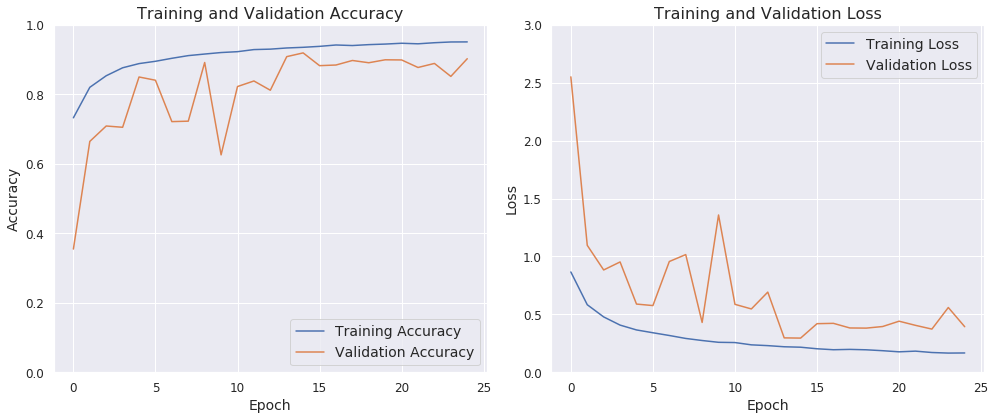

882/882 - 9s - loss: 0.2952 - sparse_categorical_accuracy: 0.9181
7063/7063 [==============================] - 5s 650us/sample
                      precision    recall  f1-score   support

               Polyp      0.625     1.000     0.769        10
Reduced Mucosal View      0.796     0.994     0.884       360
              Mucosa      0.831     0.931     0.878       174
             Unknown      0.464     0.929     0.619        14
Lymphoid Hyperplasia      0.732     0.910     0.811        78
      Foreign Bodies      0.727     0.932     0.816       117
               Ulcer      0.946     0.946     0.946       129
             Erosion      0.644     0.848     0.732        66
             Pylorus      0.555     0.943     0.699       230
    Ileo-cecal valve      0.922     0.963     0.942       629
               Blood      0.802     0.970     0.878        67
         Angiectasia      0.941     0.985     0.962       130
             Hematin      0.250     1.000     0.400         2
    

In [74]:
evaluate_model(model, history, ds, conf)

In [75]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

Press 'Interrupt Kernel' to save and exit.


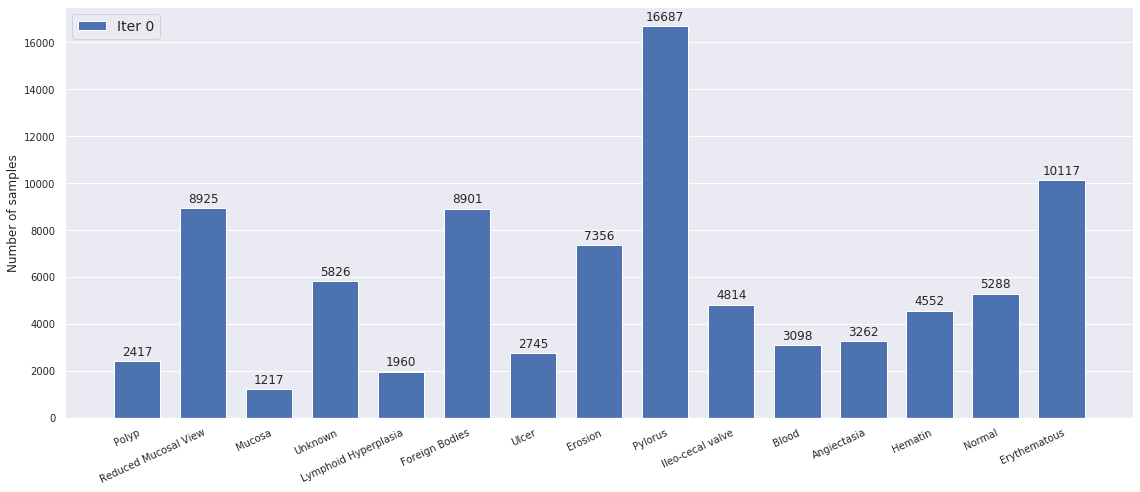


Total run time: 145.1 min.
Found 87165 new samples in unlabeled_ds after looking at 200001 images.


In [76]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [77]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

Limit set by user with 2500 samples
--------------------------------------------------
Polyp                      : added 500/2417 samples
Reduced Mucosal View       : added 500/8925 samples
Mucosa                     : added 500/1217 samples
Unknown                    : added 500/5826 samples
Lymphoid Hyperplasia       : added 500/1960 samples
Foreign Bodies             : added 500/8901 samples
Ulcer                      : added 500/2745 samples
Erosion                    : added 500/7356 samples
Pylorus                    : added 500/16687 samples
Ileo-cecal valve           : added 0/4814 samples
Blood                      : added 500/3098 samples
Angiectasia                : added 500/3262 samples
Hematin                    : added 500/4552 samples
Normal                     : added 0/5288 samples
Erythematous               : added 500/10117 samples
--------------------------------------------------
Added a total of 6500 samples to the training dataset. New dataset size is 58846.


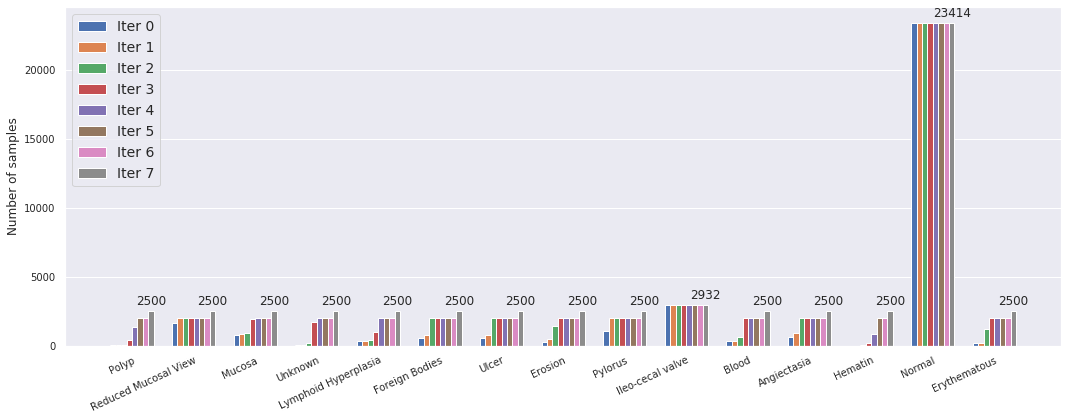

{'added_samples': 6500,
 'last_unlab_size': 2607813,
 'curr_unlab_size': 2601313,
 'last_train_size': 52346,
 'curr_train_size': 58846}

In [78]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# 4th Iteration - part 2
# -- Student 4 ---

In [79]:
# Make changes
dir_name = str(iteration)+"_student"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.6
# Model
conf["model"] = 'EfficientNetB4'
conf["dropout"] = 0.2

In [ ]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )


---- Ratios before resampling ---- 
[0.04248377 0.04248377 0.04248377 0.04248377 0.04248377 0.04248377
 0.04248377 0.04248377 0.04248377 0.04982497 0.04248377 0.04248377
 0.04248377 0.39788601 0.04248377]

---- Ratios after resampling ----


In [ ]:
# create model, callbacks and weights
model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

In [ ]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

## Evaluate the model

In [ ]:
evaluate_model(model, history, ds, conf)

In [ ]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

In [ ]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

In [ ]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# 5th iteration - Part 1
# --- Teacher 5 ---

In [ ]:
# Make changes
iteration += 1
dir_name = str(iteration)+"_teacher"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.2
# Model
conf["model"] = 'EfficientNetB0'
conf["dropout"] = 0.1

conf["class_limit"] = 3000

In [ ]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )

In [ ]:
# create model, callbacks and weights
model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

In [ ]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

## Evaluate the model

In [ ]:
evaluate_model(model, history, ds, conf)

In [ ]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

In [ ]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

In [ ]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]

# 5th Iteration - part 2
# -- Student 5 ---

In [ ]:
# Make changes
dir_name = str(iteration)+"_student"
log_dir = "./logs/{}/{}".format(project_time, dir_name)

# Dataset
conf["log_dir"] = log_dir
conf["ds_sizes"]["train"] = sanity[-1]["curr_train_size"]
conf["steps"]["train"] = sanity[-1]["curr_train_size"]//conf["batch_size"] 
conf["aug_mult"] = 0.6
# Model
conf["model"] = 'EfficientNetB4'
conf["dropout"] = 0.2

In [ ]:
ds["train"] = prepare_for_training(
        ds=ds["combined_train"], 
        ds_name='train_'+dir_name,
        conf=conf,
        cache=True
    )

In [ ]:
# create model, callbacks and weights
model = create_model(conf)
callbacks = create_callbacks(conf) 
class_weights = get_class_weights(ds["train"], conf)

In [ ]:
start_time = time.time()

history = model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"], 
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weights,
    callbacks = callbacks
)
print ("Time spent on training: {:.2f} minutes.".format(np.round(time.time() - start_time)/60))

## Evaluate the model

In [ ]:
evaluate_model(model, history, ds, conf)

In [ ]:
count = {"findings": 0, "total": 0}
pseudo = {"pred_list": [], "lab_list": [], "name_list": []}

In [ ]:
pseudo, count = generate_labels(pseudo, count, ds["unlab"], model, conf)

### Inspect the classified images

In [ ]:
# Sort in order of highest confidence to lowest
pseudo_sorted = custom_sort(pseudo)

checkout_findings(pseudo_sorted, conf, show=False)

### Resample new findings, convert to tf.tensors and concatenate with original training data, and update unlab_ds

In [ ]:
datasets_bin, added_samples = resample_and_combine(ds, conf, pseudo, pseudo_sorted, datasets_bin, limit=conf["class_limit"])

# Update unlab_ds
ds["unlab"] = reduce_dataset(ds["unlab"], remove=added_samples)

sanity, conf = update_sanity(sanity, len(added_samples), datasets_bin, conf)
sanity[-1]